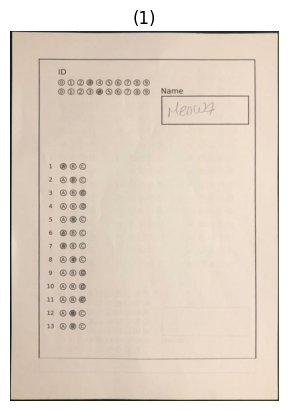

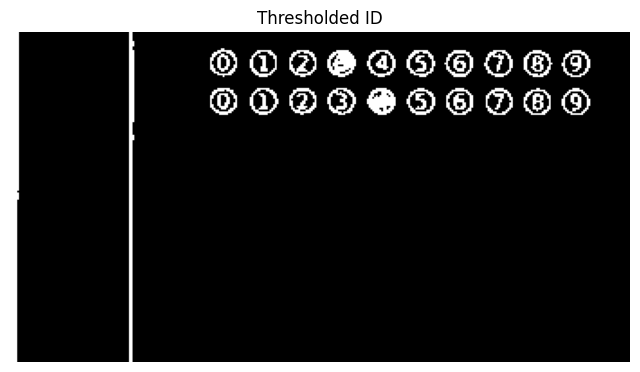

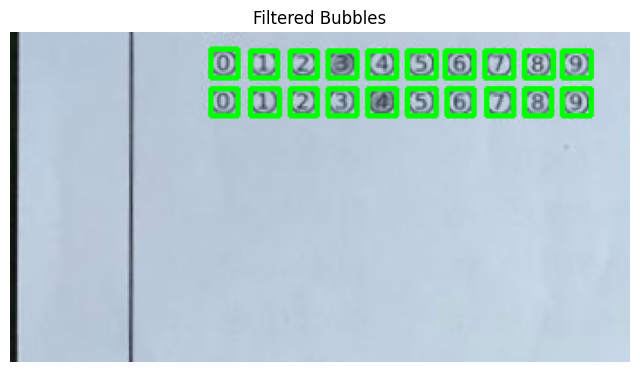

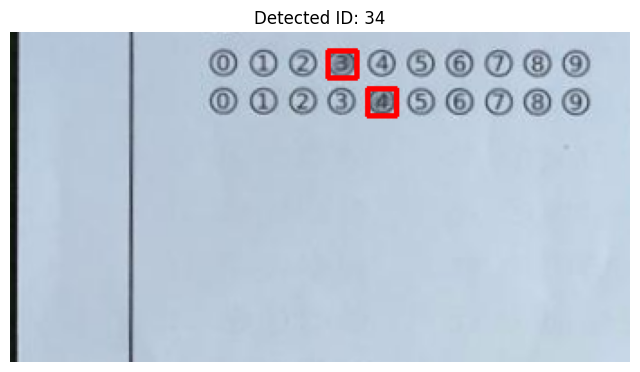

Detected ID: 34


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imutils import contours
import imutils
from paperExtraction import *

def show_image(img, title=""):
    plt.figure(figsize=(8,6))
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

def detect_id_auto(id_image, min_size=10, aspect_ratio_tol=0.2):
    """
    Detect student ID from ID image automatically (no need for number of rows).

    Args:
        id_image: Cropped ID region (BGR)
        min_size: Minimum width/height of bubble
        aspect_ratio_tol: Allowed deviation from perfect square

    Returns:
        id_number: Detected ID as string (concatenated digits)
    """
    gray = cv2.cvtColor(id_image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    show_image(thresh, "Thresholded ID")

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # Filter valid bubble contours
    bubbleCnts = []
    debug_img = id_image.copy()
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        ar = w / float(h)
        if w >= min_size and h >= min_size and abs(ar - 1) <= aspect_ratio_tol:
            bubbleCnts.append(c)
            cv2.rectangle(debug_img, (x,y), (x+w,y+h), (0,255,0), 2)
    show_image(debug_img, "Filtered Bubbles")

    if not bubbleCnts:
        return ""

    # Sort top-to-bottom
    bubbleCnts = contours.sort_contours(bubbleCnts, method="top-to-bottom")[0]

    # Split into rows automatically
    rows = []
    current_row = []
    tolerance = 10
    for c in bubbleCnts:
        x, y, w, h = cv2.boundingRect(c)
        if not current_row:
            current_row = [c]
            last_y = y
        elif abs(y - last_y) <= tolerance:
            current_row.append(c)
        else:
            rows.append(sorted(current_row, key=lambda b: cv2.boundingRect(b)[0]))
            current_row = [c]
            last_y = y
    if current_row:
        rows.append(sorted(current_row, key=lambda b: cv2.boundingRect(b)[0]))

    # Detect filled bubble in each row
    id_number = ""
    filled_img = id_image.copy()
    for row in rows:
        max_filled = 0
        filled_choice = None
        for idx, c in enumerate(row):
            mask = np.zeros(thresh.shape, dtype="uint8")
            cv2.drawContours(mask, [c], -1, 255, -1)
            filled_pixels = cv2.countNonZero(cv2.bitwise_and(thresh, thresh, mask=mask))
            if filled_pixels > max_filled:
                max_filled = filled_pixels
                filled_choice = idx
        if filled_choice is not None:
            id_number += str(filled_choice)
            x, y, w, h = cv2.boundingRect(row[filled_choice])
            cv2.rectangle(filled_img, (x,y), (x+w, y+h), (0,0,255), 2)

    show_image(filled_img, f"Detected ID: {id_number}")
    return id_number

# ----------------------------
# Example usage
# ----------------------------
imagePath = "../data/images/1.jpg"
paper = extractPaper(imagePath)
show_images([paper])
height, width, channels = paper.shape

# Automatically detect ID region in top part of paper
id_image = paper[int(0.12*height):height//3, :5*width//9, :]  # top-left region, can adjust if needed

student_id = detect_id_auto(id_image)
print("Detected ID:", student_id)
